In [1]:
from ipynb.fs.full.BreastFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd

In [639]:
# Prepare this dataframe (total results) only once

# Only load if needed to load total results from previous runs to continue on
total_results_dataframe_SVM = pd.read_csv("total_breastCancer_results_SVM.csv")
total_results_dataframe_KNN = pd.read_csv("total_breastCancer_results_KNN.csv")

# # Prepare this dataframe (total results) only once
# total_results_dataframe_SVM = pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" , "SAM Features for each tSNE run on new subset"])

# total_results_dataframe_KNN= pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" , "SAM Features for each tSNE run on new subset"])



In [533]:
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data , sample_ID_pixels = ReadBreastData()

In [507]:
# For loop run tSNE on patients
    ## Selecting Patient as test
testPatient_ID = 11
#-------------------------------------------------------
# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_ID_pixels = sample_ID_pixels )

    # Run tSNE Model
tsne_results = tSNE(train_scaled_data)
np.save("patient_TSNE/BreastCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 47588 samples in 0.005s...
[t-SNE] Computed neighbors for 47588 samples in 53.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 47588
[t-SNE] Computed conditional probabilities for sample 2000 / 47588
[t-SNE] Computed conditional probabilities for sample 3000 / 47588
[t-SNE] Computed conditional probabilities for sample 4000 / 47588
[t-SNE] Computed conditional probabilities for sample 5000 / 47588
[t-SNE] Computed conditional probabilities for sample 6000 / 47588
[t-SNE] Computed conditional probabilities for sample 7000 / 47588
[t-SNE] Computed conditional probabilities for sample 8000 / 47588
[t-SNE] Computed conditional probabilities for sample 9000 / 47588
[t-SNE] Computed conditional probabilities for sample 10000 / 47588
[t-SNE] Computed conditional probabilities for sample 11000 / 47588
[t-SNE] Computed conditional probabilities for sample 12000 / 47588
[t-SNE] Computed conditional probabilities for s

In [652]:
## Selecting Patient as test
testPatient_ID = 12
#-------------------------------------------------------

# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_ID_pixels = sample_ID_pixels )



In [653]:
tsne_results = np.load("patient_TSNE/BreastCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

In [654]:
kmeans_8 , kmeans_7, kmeans_6, kmeans_5 = KMeans_results(tsne_results)

In [655]:
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx","Breast Cancer Clinical Data")

NonMetastasis: [6. 1. 1. 1. 3. 3. 1. 0.]
Metastasis: [1. 4. 6. 3. 3. 2. 8. 1.]


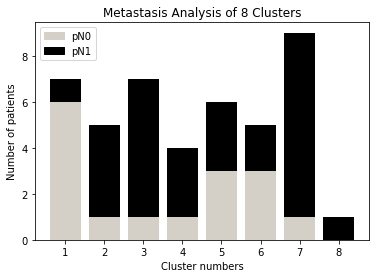

NonMetastasis: [2. 2. 1. 7. 1. 2. 4.]
Metastasis: [5. 4. 4. 2. 9. 1. 2.]


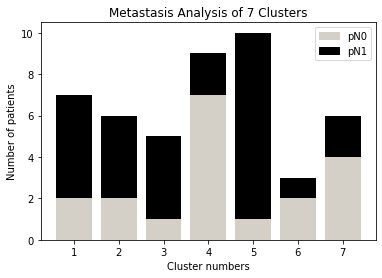

NonMetastasis: [1. 3. 2. 5. 3. 1.]
Metastasis: [3. 3. 5. 3. 4. 8.]


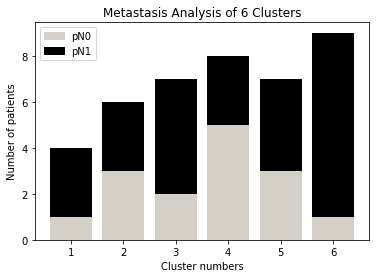

NonMetastasis: [3. 1. 3. 3. 3.]
Metastasis: [ 3.  3.  5. 10.  3.]


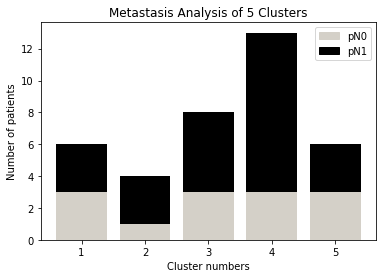

In [656]:
# Returns Non-Metastasis and Metastasis clusters
state08, state18 = metastasis_status(kmeans_8.labels_, Clinical_data,train_ID_pixels)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data,train_ID_pixels)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data,train_ID_pixels)
state05, state15 = metastasis_status(kmeans_5.labels_, Clinical_data,train_ID_pixels)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
plot_metastasis_status(state05, state15)

# Create dict to save kmeans results and select them later
kmeans_dict = {"8_Clusters": [kmeans_8.labels_,state08] , "7_Clusters": [kmeans_7.labels_,state07]  , "6_Clusters": [kmeans_6.labels_,state06] , "5_Clusters": [kmeans_5.labels_,state05] }

In [657]:
# Select the correct kmeans that shows best results from metastasis analysis, must have one fully metastasis cluster
selected_clusters_value = 8

# ----------------------------------------------------------------------------------

# Detect the fully metastasis cluster, select the correct kmeans that shows best results from metastasis analysis
labels = kmeans_dict[str(selected_clusters_value)+"_Clusters"][0]
selected_state = kmeans_dict[str(selected_clusters_value)+"_Clusters"][1]

fully_metastasis_cluster_label = 0
for cluster in selected_state:
    if not cluster: # Cluster list is empty, has no healthy patients, so it's fully metastasis cluster
        break # fully_metastasis_cluster_label now has the right label, exit loop
    
    fully_metastasis_cluster_label += 1

print("Fully metastasis cluster label's index is {} and it is cluster {}".format(fully_metastasis_cluster_label,fully_metastasis_cluster_label+1))

Fully metastasis cluster label's index is 7 and it is cluster 8


In [658]:
# Run R file in order to generate significant proteins using the csv file
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, fully_metastasis_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

In [626]:
#Need to read significant protein file outputted from R

SAM_protein = readSignificantProteins("significant_breast_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_breast_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, fully_metastasis_cluster_label)

In [627]:
SAM_protein

[4999, 4965, 5171, 5067, 9265, 6980]

In [628]:
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 0.1 , train_scaled_selected_proteins_data , train_labels , test_scaled_selected_proteins_data)

In [638]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 50.12333497779971 
Non-Metastasis probability : 49.87666502220029


In [610]:
y_pred_KNN = KNN(5 , train_scaled_selected_proteins_data, train_labels, test_scaled_selected_proteins_data)

In [629]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 25.900345337937843 
Non-Metastasis probability : 74.09965466206216


In [630]:
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_SVM
Metastasis_prob = Selected_model[0]
Non_Metastasis_prob = Selected_model[1]

In [631]:
# Run after model complete to save the result in the total results dataframe
total_results_dataframe_SVM = OutputDataframe(total_results_dataframe_SVM, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value, SAM_protein)

In [632]:
total_results_dataframe_SVM

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,SAM Features for each tSNE run on new subset
0,1,74.916388,25.083612,2,1,8,"Significant Features : m/z = [6650, 4999, 6277..."
1,2,83.548009,16.451991,2,1,8,"Significant Features : m/z = [4965, 4999, 5171..."
2,3,53.247312,46.752688,2,1,5,"Significant Features : m/z = [4999, 6980, 4965..."
3,4,90.439133,9.560867,2,1,5,"Significant Features : m/z = [4965, 5171, 4999..."
4,5,88.451304,11.548696,2,1,7,"Significant Features : m/z = [4965, 4999, 5171]"
5,6,62.598425,37.401575,2,1,8,"Significant Features : m/z = [6277, 11652, 665..."
6,7,88.387097,11.612903,2,1,7,"Significant Features : m/z = [4999, 4965, 5067..."
7,8,55.007364,44.992636,2,1,6,"Significant Features : m/z = [6650, 6277, 4999..."
0,9,70.218228,29.781772,2,1,8,"Significant Features : m/z = [11652, 6650, 499..."
0,10,59.580838,40.419162,2,1,7,"Significant Features : m/z = [6980, 4965, 4999..."


In [633]:
total_results_dataframe_SVM.to_csv("total_breastCancer_results_SVM.csv" , index = False)

In [634]:
Selected_model = Surv_KNN
Metastasis_prob = Selected_model[0]
Non_Metastasis_prob = Selected_model[1]

In [635]:
total_results_dataframe_KNN = OutputDataframe(total_results_dataframe_KNN, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value, SAM_protein)

In [636]:
total_results_dataframe_KNN

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,SAM Features for each tSNE run on new subset
0,1,58.231141,41.768859,2,1,8,"Significant Features : m/z = [6650, 4999, 6277..."
1,2,74.297424,25.702576,2,1,8,"Significant Features : m/z = [4965, 4999, 5171..."
2,3,51.612903,48.387097,2,1,5,"Significant Features : m/z = [4999, 6980, 4965..."
3,4,87.993330,12.006670,2,1,5,"Significant Features : m/z = [4965, 5171, 4999..."
4,5,75.944651,24.055349,2,1,7,"Significant Features : m/z = [4965, 4999, 5171]"
5,6,54.921260,45.078740,2,1,8,"Significant Features : m/z = [6277, 11652, 665..."
6,7,78.207885,21.792115,2,1,7,"Significant Features : m/z = [4999, 4965, 5067..."
7,8,58.173785,41.826215,2,1,6,"Significant Features : m/z = [6650, 6277, 4999..."
0,9,67.394095,32.605905,2,1,8,"Significant Features : m/z = [11652, 6650, 499..."
0,10,60.179641,39.820359,2,1,7,"Significant Features : m/z = [6980, 4965, 4999..."


In [637]:
total_results_dataframe_KNN.to_csv("total_breastCancer_results_KNN.csv" , index = False)